# Queen's Christmas Broadcast Cleaning

We will expand upon our previous work by cleaning the locally stored text files we've already downloaded using the web crawler Notebook.

Our first task is to gain a thorough understanding of our input and define our desired output.This initial step will significantly clarify our approach to effectively clean the data.

## The input

After a brief examination of the text files, you will find they may contain three sections: 
- "Abstract" 
This section is a short quote from the speech.
- "Introduction"
The introduction is a short introduction to the speech and its context. It is not narrated by the Queen.
- "Main Text" 
This is the main text of the speech.

It's important to note that not all transcripts have all three sections; some of them only have two, while others may only feature the "Main Text". As exemplified in speeches [1971](https://www.royal.uk/christmas-broadcast-1971), [1982](https://www.royal.uk/christmas-broadcast-1982), and [2019](https://www.royal.uk/queen%E2%80%99s-christmas-broadcast-2019), the formats vary.

Below you can find an illustration of how the webpage of a speech looks like that includes all three parts:

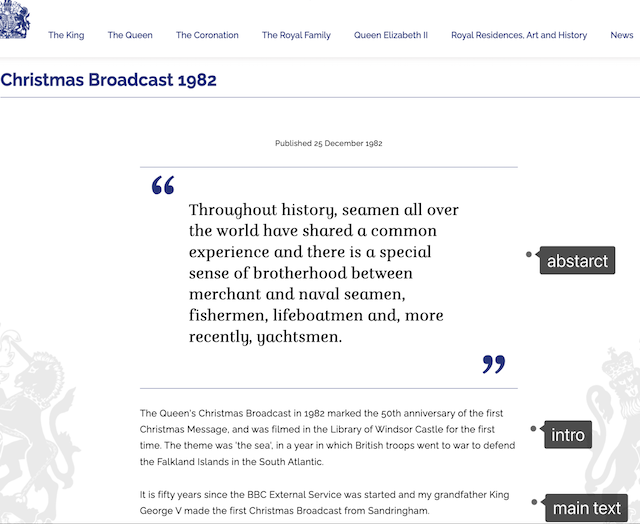

- metadata.csv
- content/labeled_text_files

Unfortunately, we inspected the HTML and these different sections are not always distinguished by an html element with specific class or ID. This variation means that we cannot easily automate the extraction of these sections computationally; manual annotation is required.

## Desired output

After running the cells in this Notebook you will create several outputs:
1. A folder titled **'cleaned_text_files'** of all the cleaned main texts, located in the content folder
2. A CSV file titled **'data.csv'** with the cleaned and labeled text
3. A CSV file titled **'enriched_corpus.csv'** with the fully preprocessed text (tokens + lemmas) and metadata

## Manual Labeling

Our first step involves manual labeling of the sections. We placed a "#" symbol before the "Abstract" section, a "@" before the "Introduction" section, and leave no symbol before the "Main Text" section.

All labeled text files can be found in the folder named 'labeled_text_files'. Please make sure to download it to the same folder as this notebook to ensure that everything runs smoothly.

## Import libraries



To start the preprocessing and cleaning we need to load several libaries:

In [ ]:
# Google Colab users, please run this cell before others

!pip install chardet

from google.colab import files

In [59]:
import os # same as crawler

import csv # creating and managing CSV files efficiently

import chardet # detecting file's character encoding

import pandas as pd
from pathlib import Path

## Extract sections from the text files

Note: I used Google Colab for this task. If you're also on it, please upload the "labeled_text_files" to the CONTENT section. If you prefer a different platform, simply **create a folder titled 'content' and move the 'labeled_text_files' folder to it so that the filepath is correct**.

In [58]:
folder_name = 'content/labeled_text_files'

We noticed, that some of these text files have different encodings. Therefore for our cleaning process we are creating a function that can identify the encoding of the file to be opened and then open the file with that encoding. We are using the chardet libary for this purpose.

In [60]:
def open_file(file_path):
    
# first we are checking the encoding of the file, unfortunately it can differ  
# some of the files are actually encoded in ASCII and other encodings as well

    with open(file_path, 'rb') as file:
        raw_data = file.read()
        encoding_result = chardet.detect(raw_data)
        file_encoding = encoding_result['encoding']
        #print(encoding_result['encoding']) # we can check the different encodings of these files
    
    with open(file_path, 'r', encoding= file_encoding) as file:
        content = file.read()
        title = os.path.splitext(os.path.basename(file_path))[0].strip() # extract the file name as the title
    return content, title

#open_file('content/labeled_text_files/1972.txt') # You can use this to test our new created function!

Great, this will help us open all the texts without any issues.

Next we have two things we are cleaning:

1. **The date of publication:**
In each text file, the first three lines meantion the date of publication. We are not interested in this information as we already have the year of publication in the title of the file, rendering the date of publication redundant. Thus, we can start from the fourth line for the cleaning. Since the transcript is organized by linebreaks, we can use this consistent pattern to split the text. This approach helps ensure that the text's structural integrity is maintained.

2. **Noise at the end of the transcript:**
Additionally, we are removing all the text that follows after the "Share this article:" button. This button always comes at the end of the transcript and we can split the text from there to make sure to eliminate any noise. 

We are then using our labels mentioned earlier (#,@) to assign the different sections of text. We will use a dictonary to save the cleaned data for each transcript. Considering that certain sections might not exist: If a marker is missing, the corresponding section is set to 'N/A' to avoid KeyError. The unmarked paragraphs left are treated as the main text.

In [62]:
# looping through each file in the specified folder
# to keep track of the extracted data before adding it to the final list (data_list)

data_list = []  # list for storing data of each file

for filename in os.listdir(folder_name):
    file_path = os.path.join(folder_name, filename)
    text, title = open_file(file_path)
    
    # data_dict is a temporary container

    data_dict = {'Title': title, 'Abstract': 'N/A', 'Intro': 'N/A', 'MainText': 'N/A'} # all initially set to 'N/A'
    
    #Cleaning out the noise
    
    paragraphs = text.split("Share this article:")
    paragraphs = ''.join(paragraphs)
    paragraphs = paragraphs.split('\n')[3:] # split paragraph and starting from the fourth one
    
    
    # Going through each paragraph in paragraphs using a for loop
    # categorizes based on the manual labels '#' '@'

    main_text = ''
    
    for para in paragraphs:
        if para.startswith('#'):
            data_dict['Abstract'] = para.replace('#', '').strip()
        elif para.startswith('@'):
            data_dict['Intro'] = para.replace('@', '').strip()
        else:
            main_text += para.strip('') # leading and trailing spaces removed

    # Removing copy right text in the transcripts
    data_dict['MainText'] = main_text.replace('The Royal Household © Crown Copyright','').strip('')
    
    # Creating a list with all the cleaned and labeled texts dictonaries
    data_list.append(data_dict)

In [93]:
# print one of the dic in the list we have to check if everything works

print(data_list[0])

# awesome! it's working!

{'Title': '2002', 'Abstract': 'All great religions have such times of renewal, moments to take stock before moving on to face the challenges which lie ahead.', 'Intro': "In 2002 The Queen celebrated her Golden Jubilee (50 years as Queen). She also lost her mother and sister within a few weeks of each other. The Queen's Christmas Broadcast in 2002 reflected on the celebrations which had taken place around the UK and Commonwealth, and looked forward to the challenges of the future.", 'MainText': 'As I look back over these past twelve months, I know that it has been about as full a year as I can remember. But Christmas itself still remains a time for reflection and a focus of hope for the future.All great religions have such times of renewal, moments to take stock before moving on to face the challenges which lie ahead.Many of you will know only too well from your own experience, the grief that follows the death of a much loved mother or sister. Mine were very much part of my life and alw

## Clean and Count

To obtain processed text data that is both standardized and easier to manage, make sure not to overlook the removal of extra spaces. You may wonder why this step matters. Let me provide an example. The two phrases convey the same meaning; however, the first one has two more letters than the latter. If you're aiming to glean insights from word counts, it's essential to be mindful of this particular step.

> ' Happy New Year! '

> 'Happy New Year!'



Additionally, we should handle punctuation carefully. Sometimes preserving the punctuation helps maintain text clarity. For example, consider the distinction between



> 'Let's eat, Max!'


> 'Lets eat Max'





Thus, we can define two functions, one with punctuation and one without punctuation, to clean the text. These functions can be easily adjusted to suit different situations.

In [64]:
def clean_no_punc(text):
    cleaned_text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    cleaned_text = ' '.join(cleaned_text.split())
    return cleaned_text

def clean_with_punc(text):
    cleaned_text = ' '.join(text.split())
    return cleaned_text

In [65]:
# Feel free to run this cell and observe the distinction

text = '   I   like   space     !    '

print(clean_no_punc(text))
print(clean_with_punc(text))

I like space
I like space !


Similarly, the issue extends to word counts. Therefore, we can also define two functions, one considering punctuation and the other without it, to count the words.

In [66]:
def count_no_punc(text):
    cleaned_text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    cleaned_text = ' '.join(cleaned_text.split())
    words = cleaned_text.split()
    word_count = len(words)
    return word_count

def count_with_punc(text):
    words = text.split()
    word_count = len(words)
    return word_count

In [67]:
# Feel free to run this cell and observe the distinction

text = '   I   like   space     !    '

print(count_no_punc(text))
print(count_with_punc(text))

3
4


How about combining text cleaning and word counting?

In [68]:
def clean_and_count_no_punc(text):
    cleaned_text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    cleaned_text = ' '.join(cleaned_text.split())
    words = cleaned_text.split()
    word_count = len(words)
    return cleaned_text, word_count

def clean_and_count_with_punc(text):
    words = text.split()
    cleaned_text = ' '.join(words)
    word_count = len(words)
    return cleaned_text, word_count

In [69]:
# Feel free to run this cell and observe the difference

text = '   I   like   space     !    '

print(clean_and_count_no_punc(text))
print(clean_and_count_with_punc(text))

('I like space', 3)
('I like space !', 4)


Let's call the "clean_and_count_with_punc" function that we defined to process the abstract, introduction, and main text sections. This way, each text section retains its original punctuation while also calculating the word count of the cleaned text. The cleaned text is stored in a new key with a 'Cleaned' prefix, and the word count is stored in a new key with a 'WordCount' suffix.

In [70]:
for data in data_list: # through each dictionary in data_list
    for part in ['Abstract', 'Intro', 'MainText']: # through each of the 'Abstract', 'Intro', and 'MainText' keys
        if data[part] != 'N/A':
            cleaned_text, word_count = clean_and_count_with_punc(data[part])

# store the data
            data[f'Cleaned{part}'] = cleaned_text
            data[f'{part}WordCount'] = word_count


In [71]:
# print the results to confirm

print(data_list[1])

# excellent work! we're half way there!

{'Title': '2016', 'Abstract': 'I wish you all a very happy Christmas', 'Intro': 'N/A', 'MainText': "There was a time when British Olympic medal winners became household names because there were so few of them.\xa0 But the 67 medals at this year’s Games in Rio and 147 at the Paralympics meant that the GB medallists' reception at Buckingham Palace was a crowded and happy event.\xa0 Throughout the Commonwealth there were equally joyful celebrations.\xa0 Grenada, the Bahamas, Jamaica and New Zealand won more medals per head of population than any other countries.\xa0Many of this year’s winners spoke of being inspired by athletes of previous generations.\xa0 Inspiration fed their aspiration; and having discovered abilities they scarcely knew they had, these athletes are now inspiring others.A few months ago, I saw inspiration of a different kind when I opened the new Cambridge base of the East Anglian Air Ambulance, where Prince William works as a helicopter pilot.\xa0 It was not hard to be

## Create CSV files

Now, we're ready to create some beautiful CSV files with clear structure and valuable information. It's important to remember that, even if some speeches don't have an abstract or introduction, they still have significance and should be included in our CSV files.

As the titles are represented as years, we aim to transform them into integers and sort them in ascending order, to present the corpus in a cleaner and more accessible way.

In [72]:
def sort_key(data_dict):
    return int(data_dict['Title'])

def write_csv(file_name, data_list):
    sorted_data_list = sorted(data_list, key=sort_key)

    with open(file_name, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        # insert columns
        columns = ['Title', 
                   'CleanedAbstract', 
                   'AbstractWordCount',
                   'CleanedIntro', 
                   'IntroWordCount',
                   'CleanedMainText',
                   'MainTextWordCount']
        writer.writerow(columns)

        # insert data
        for data in sorted_data_list:
            row = [
                data['Title'],
                data.get('Abstract', 'N/A'),
                data.get('AbstractWordCount', 'N/A'),
                data.get('Intro', 'N/A'),
                data.get('IntroWordCount', 'N/A'),
                data.get('CleanedMainText', 'N/A'),
                data.get('MainTextWordCount', 'N/A')
            ]
            writer.writerow(row)

corpus_file_name = 'data.csv'
write_csv(corpus_file_name, data_list)

print("The CSV document has been saved")

The CSV document has been saved


## Adding meta data

We manually collected metadata, which we will now merge with the csv file we just created.
Please make sure you have downloaded the `metadata.csv` file in the same folder as this Notebook before running the following cells.

In [73]:
import pandas as pd

In [74]:
# Let's create a Pandas Data Frame for our CSV files to merge them

corpus_df = pd.read_csv(corpus_file_name) #Creating a corpus DF


metadata_df = pd.read_csv('metadata.csv')

# Merge metadata and songs into new Data Frame

corpus_df.head()

final_corpus_df = pd.merge(
    metadata_df,
    corpus_df,
    how="inner",
    left_on='year',
    right_on='Title')

# Let's see if that worked out
final_corpus_df.head()

,year,monarch,media,channel,place,context,Title,CleanedAbstract,AbstractWordCount,CleanedIntro,IntroWordCount,CleanedMainText,MainTextWordCount
0,1952,Elizabeth II,Radio,BBC,NaN,NaN,1952,"Since my accession ten months ago, your loyalt...",34.0,"After her Accession on 6 February 1952, The Qu...",49.0,"Each Christmas, at this time, my beloved fathe...",1230
1,1953,Elizabeth II,Radio,BBC,"Auckland, NZ",NaN,1953,At the same time I want to show that the Crown...,30.0,At the end of 1953 The Queen and The Duke of E...,49.0,Last Christmas I spoke to you from England; th...,1433
2,1954,Elizabeth II,Radio,BBC,Sandringham House,NaN,1954,"So, our Commonwealth hearth becomes more preci...",39.0,The Queen's Christmas Broadcast in 1954 came a...,43.0,It is now two years since my husband and I spe...,1180
3,1955,Elizabeth II,Radio,BBC,Sandringham House,NaN,1955,"I always feel that just for these few minutes,...",28.0,In 1955 The Queen's Christmas Message was broa...,27.0,"No doubt you have been listening, as I have, t...",1297
4,1956,Elizabeth II,Radio,BBC,Sandringham House,NaN,1956,Neither the long and troubled centuries that h...,41.0,On Christmas Day in 1956 The Duke of Edinburgh...,44.0,Once again messages of Christmas greeting have...,1408


Awesome! Now, we have a Data Frame, which we can use for futher text processing. There are several things to note however:
1. We now have the year of the speech twice, once in the 'year' column and once in the 'Title' column. I will drop the latter to remove redundancy.

2. We can see that the "AbstractWordCount" and "IntroWordCount" are of type Float, whereas the MainTextWordCount is of type Intenger as expected. Why could that be? It seems that Pandas initiates numbers as Floats, when there are rows missing from your column. For now, it's not a big issue but just good to keep in mind.

In [75]:
final_corpus_df.drop(columns='Title')

,year,monarch,media,channel,place,context,CleanedAbstract,AbstractWordCount,CleanedIntro,IntroWordCount,CleanedMainText,MainTextWordCount
0,1952,Elizabeth II,Radio,BBC,NaN,NaN,"Since my accession ten months ago, your loyalt...",34.0,"After her Accession on 6 February 1952, The Qu...",49.0,"Each Christmas, at this time, my beloved fathe...",1230
1,1953,Elizabeth II,Radio,BBC,"Auckland, NZ",NaN,At the same time I want to show that the Crown...,30.0,At the end of 1953 The Queen and The Duke of E...,49.0,Last Christmas I spoke to you from England; th...,1433
2,1954,Elizabeth II,Radio,BBC,Sandringham House,NaN,"So, our Commonwealth hearth becomes more preci...",39.0,The Queen's Christmas Broadcast in 1954 came a...,43.0,It is now two years since my husband and I spe...,1180
3,1955,Elizabeth II,Radio,BBC,Sandringham House,NaN,"I always feel that just for these few minutes,...",28.0,In 1955 The Queen's Christmas Message was broa...,27.0,"No doubt you have been listening, as I have, t...",1297
4,1956,Elizabeth II,Radio,BBC,Sandringham House,NaN,Neither the long and troubled centuries that h...,41.0,On Christmas Day in 1956 The Duke of Edinburgh...,44.0,Once again messages of Christmas greeting have...,1408
...,...,...,...,...,...,...,...,...,...,...,...,...
67,2019,Elizabeth II,TV,BBC,Windsor Castle,NaN,NaN,NaN,NaN,NaN,"As a child, I never imagined that one day a ma...",856
68,2020,Elizabeth II,TV,BBC,NaN,"first time available on Amazon's ""Alexa"" device","Remarkably, a year that has necessarily kept p...",38.0,NaN,NaN,Every year we herald the coming of Christmas b...,858
69,2021,Elizabeth II,TV,ITN,Windsor Castle,NaN,"And for me and my family, even with one famili...",49.0,NaN,NaN,Although it’s a time of great happiness and go...,702
70,2022,Charles VI,TV,BBC,Windsor Castle,NaN,Christmas is a particularly poignant time for ...,33.0,His Majesty reflects on Queen Elizabeth II's f...,21.0,I am standing here in this exquisite Chapel of...,614


## Enriching our data set with NLTK processing

In order to get some more value out of our corpus, we now turn to tokenizing and lemmatizing the main text in our corpus and incorporating this into a final `enriched_corpus.csv` file.

First we will start with tokenization:

In [94]:
# Make sure you have the NLTK toolkit and wordnet downloaded
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/miriamweigand/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

Let's define the functions for tokenizing and lemmatizing:
1. `tokenize_words` tokenizes the entire text into a list of words
2. `tokenize_sen` tokenizes all words per sentences
3. `lemmatize_list` goes through a list of words and lemmatizes all words. 
The function goes through a list, as the tokenizes words are saved in list format in the CSV column

In [87]:

### PREPROCESSING FUNCTIONS ###################################################################


def tokenize_words(sent):
    return [token.lower() for token in nltk.word_tokenize(sent)
           if token not in ".,?!:;()[]''``*"]

def tokenize_sen(text):
    return [tokenize_words(sent) for sent in nltk.sent_tokenize(text)]


### LEMMATIZER  ##############################################################################

lem = WordNetLemmatizer()

# the function for lemmatizing:

# lem.lemmatize()

def lemmatize_list(word_list):
    return [lem.lemmatize(word) for word in word_list]

Let's see how the tokenizers perform in action. Run the cell below as an example:

In [97]:
example = 'Since my accession ten months ago, your loyalty and affection have been an immense support and encouragement. I want to take this Christmas Day, my first opportunity, to thank you with all my heart.'

print(tokenize_words(example)) #tokenizes texts into a list of words, punctuation removed

print(tokenize_sen(example)) #tokenizes texts into a list of sentences

['since', 'my', 'accession', 'ten', 'months', 'ago', 'your', 'loyalty', 'and', 'affection', 'have', 'been', 'an', 'immense', 'support', 'and', 'encouragement', 'i', 'want', 'to', 'take', 'this', 'christmas', 'day', 'my', 'first', 'opportunity', 'to', 'thank', 'you', 'with', 'all', 'my', 'heart']
[['since', 'my', 'accession', 'ten', 'months', 'ago', 'your', 'loyalty', 'and', 'affection', 'have', 'been', 'an', 'immense', 'support', 'and', 'encouragement'], ['i', 'want', 'to', 'take', 'this', 'christmas', 'day', 'my', 'first', 'opportunity', 'to', 'thank', 'you', 'with', 'all', 'my', 'heart']]


Finally, we can use our functions to add new columns to our Dataframe!

In [98]:
# Create the WordTokensMain column:
final_corpus_df['WordTokensMain'] = final_corpus_df['CleanedMainText'].apply(tokenize_words)

# Create the SentenceTokensMain column:
final_corpus_df['SentenceTokensMain'] = final_corpus_df['CleanedMainText'].apply(tokenize_sen)

# To check the newly created columns
final_corpus_df.head()

,year,monarch,media,channel,place,context,Title,CleanedAbstract,AbstractWordCount,CleanedIntro,IntroWordCount,CleanedMainText,MainTextWordCount,WordTokensMain,SentenceTokensMain,LemmasMain
0,1952,Elizabeth II,Radio,BBC,NaN,NaN,1952,"Since my accession ten months ago, your loyalt...",34.0,"After her Accession on 6 February 1952, The Qu...",49.0,"Each Christmas, at this time, my beloved fathe...",1230,"[each, christmas, at, this, time, my, beloved,...","[[each, christmas, at, this, time, my, beloved...","[each, christmas, at, this, time, my, beloved,..."
1,1953,Elizabeth II,Radio,BBC,"Auckland, NZ",NaN,1953,At the same time I want to show that the Crown...,30.0,At the end of 1953 The Queen and The Duke of E...,49.0,Last Christmas I spoke to you from England; th...,1433,"[last, christmas, i, spoke, to, you, from, eng...","[[last, christmas, i, spoke, to, you, from, en...","[last, christmas, i, spoke, to, you, from, eng..."
2,1954,Elizabeth II,Radio,BBC,Sandringham House,NaN,1954,"So, our Commonwealth hearth becomes more preci...",39.0,The Queen's Christmas Broadcast in 1954 came a...,43.0,It is now two years since my husband and I spe...,1180,"[it, is, now, two, years, since, my, husband, ...","[[it, is, now, two, years, since, my, husband,...","[it, is, now, two, year, since, my, husband, a..."
3,1955,Elizabeth II,Radio,BBC,Sandringham House,NaN,1955,"I always feel that just for these few minutes,...",28.0,In 1955 The Queen's Christmas Message was broa...,27.0,"No doubt you have been listening, as I have, t...",1297,"[no, doubt, you, have, been, listening, as, i,...","[[no, doubt, you, have, been, listening, as, i...","[no, doubt, you, have, been, listening, a, i, ..."
4,1956,Elizabeth II,Radio,BBC,Sandringham House,NaN,1956,Neither the long and troubled centuries that h...,41.0,On Christmas Day in 1956 The Duke of Edinburgh...,44.0,Once again messages of Christmas greeting have...,1408,"[once, again, messages, of, christmas, greetin...","[[once, again, messages, of, christmas, greeti...","[once, again, message, of, christmas, greeting..."


In [90]:
# Create the LemmasMain column:
final_corpus_df['LemmasMain'] = final_corpus_df['WordTokensMain'].apply(lemmatize_list)
 
    
# To check the newly created columns
final_corpus_df.head()

,year,monarch,media,channel,place,context,Title,CleanedAbstract,AbstractWordCount,CleanedIntro,IntroWordCount,CleanedMainText,MainTextWordCount,WordTokensMain,SentenceTokensMain,LemmasMain
0,1952,Elizabeth II,Radio,BBC,NaN,NaN,1952,"Since my accession ten months ago, your loyalt...",34.0,"After her Accession on 6 February 1952, The Qu...",49.0,"Each Christmas, at this time, my beloved fathe...",1230,"[each, christmas, at, this, time, my, beloved,...","[[each, christmas, at, this, time, my, beloved...","[each, christmas, at, this, time, my, beloved,..."
1,1953,Elizabeth II,Radio,BBC,"Auckland, NZ",NaN,1953,At the same time I want to show that the Crown...,30.0,At the end of 1953 The Queen and The Duke of E...,49.0,Last Christmas I spoke to you from England; th...,1433,"[last, christmas, i, spoke, to, you, from, eng...","[[last, christmas, i, spoke, to, you, from, en...","[last, christmas, i, spoke, to, you, from, eng..."
2,1954,Elizabeth II,Radio,BBC,Sandringham House,NaN,1954,"So, our Commonwealth hearth becomes more preci...",39.0,The Queen's Christmas Broadcast in 1954 came a...,43.0,It is now two years since my husband and I spe...,1180,"[it, is, now, two, years, since, my, husband, ...","[[it, is, now, two, years, since, my, husband,...","[it, is, now, two, year, since, my, husband, a..."
3,1955,Elizabeth II,Radio,BBC,Sandringham House,NaN,1955,"I always feel that just for these few minutes,...",28.0,In 1955 The Queen's Christmas Message was broa...,27.0,"No doubt you have been listening, as I have, t...",1297,"[no, doubt, you, have, been, listening, as, i,...","[[no, doubt, you, have, been, listening, as, i...","[no, doubt, you, have, been, listening, a, i, ..."
4,1956,Elizabeth II,Radio,BBC,Sandringham House,NaN,1956,Neither the long and troubled centuries that h...,41.0,On Christmas Day in 1956 The Duke of Edinburgh...,44.0,Once again messages of Christmas greeting have...,1408,"[once, again, messages, of, christmas, greetin...","[[once, again, messages, of, christmas, greeti...","[once, again, message, of, christmas, greeting..."


- Write note on lemmatizer and how verbs are not recognized as verbs per se and then not lemmatized the same way. I will not fix this issue but just leave it for now, this article explains it https://stackoverflow.com/questions/25534214/nltk-wordnet-lemmatizer-shouldnt-it-lemmatize-all-inflections-of-a-word

Let's save the final data frame!

In [91]:
final_corpus_df.to_csv('enriched_corpus.csv', index=False)

## Create TXT files (Completely Cleaned MainText)

For further analysis, we will create a folder of txt files of the cleaned main text.

### Extract from CSV



> **Google Colab users, please run this cell**

In [ ]:
csv_file = '/content/data.csv'  # Colab's path of the CSV file
data = pd.read_csv(csv_file)

title_column = 'Title'
clean_column = 'CleanedMainText'
title_data = data[title_column]
clean_data = data[clean_column]

txt_dir = Path('/content/cleaned text files') # output folder path of the txt files
txt_dir.mkdir(parents=True, exist_ok=True)

# store the data
for title, clean in zip(title_data, clean_data):
    txt_file = txt_dir / f'{title}cleaned.txt'
    with txt_file.open('w', encoding='utf-8') as file:
        file.write(str(clean))

print("cleaned txt files have been saved in Colab")



> **Otherwise, this cell**



In [ ]:
csv_file = 'data.csv'  # local path of the CSV file
data = pd.read_csv(csv_file)

title_column = 'Title'
clean_column = 'CleanedMainText'
title_data = data[title_column]
clean_data = data[clean_column]

output_folder = 'content/cleaned_text_files'  # output folder path of the txt files
os.makedirs(output_folder, exist_ok=True) #creating the output folder

# store the data
for title, clean in zip(title_data, clean_data):
    txt_file_name = os.path.join(output_folder, f'{title}_cleaned.txt')
    with open(txt_file_name, 'w', encoding='utf-8') as file:
        file.write(str(clean))

print("cleaned txt files have been saved in local")


In [ ]:
# SAVE the Cleaned text back into the column CleanedMainText of the CSV file